In [2]:
import anndata as ad
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
%run -i 0_functions.py

In [4]:
id_name = {}

counter = 0
division = 5
for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "mono"}
        # print(counter)
        counter += 1

for i in [1, 2, 3]:
    for j in range(division):
        id_name[counter] = {"rep": i, "subset": j, "cell_type": "ery"}
        # print(counter)
        counter += 1

In [5]:
results_all_subsets = pickle.load(open("data/results_dynchro_hvg_subsets.pkl", "rb"))

# Bad alignment

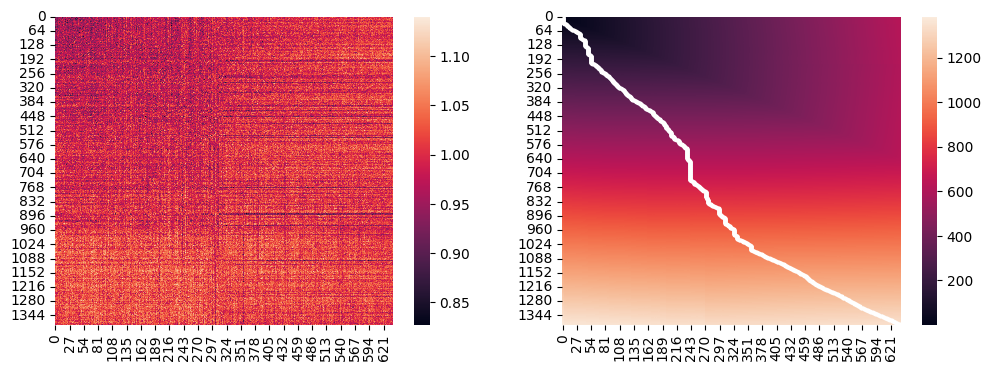

In [6]:
res1 = results_all_subsets[10][23][0]
res1.plot_cost_distances()

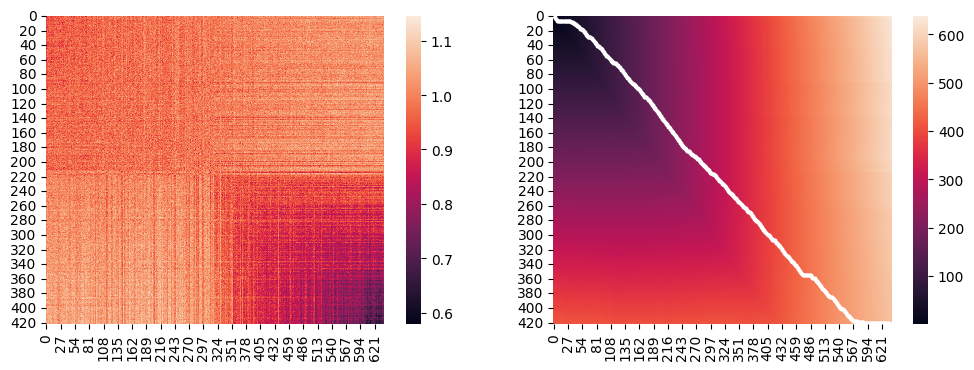

In [7]:
results_all_subsets[15][23][0].plot_cost_distances()

start with results_all_subsets 10, 23

In [8]:
dataset1 = read_with_pc(f"data/rep{id_name[10]['rep']}_{id_name[10]['cell_type']}_subset{id_name[10]['subset']}_hvg.h5ad")
dataset2 = read_with_pc(f"data/rep{id_name[23]['rep']}_{id_name[23]['cell_type']}_subset{id_name[23]['subset']}_hvg.h5ad")

In [9]:
def skip_traceback_free(D):
    # start from smallest value on the last column --> refers to i and p
    i = np.argmin(D[:, -1])
    j = D.shape[1] - 1

    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = np.argmin((D[i - 1, j - 1], D[i, j - 1], D[i - 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            j -= 1
        elif tb == 2:
            i -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

In [13]:
dist1 = res1.distances()
path1, path2 = skip_traceback_free(dist1)

In [67]:
def avg_cost_path(path1, path2, matrix, dataset1, dataset2):
    sorted_names1 = dataset1.obs["pseudotime"].sort_values().index
    sorted_names2 = dataset2.obs["pseudotime"].sort_values().index
    # print(sorted_names1[0])

    avg_cost1 = defaultdict(list)
    avg_cost2 = defaultdict(list)

    for p1, p2 in zip(path1, path2):
        cost = matrix[p1-1, p2-1]
        # print(p1, p2)
        avg_cost1[sorted_names1[p1-1]].append(cost)
        avg_cost2[sorted_names2[p2-1]].append(cost)

    index1 = list(avg_cost1.keys())
    index2 = list(avg_cost2.keys())
    ac1 = [sum(x) / len(x) for x in avg_cost1.values()]
    ac2 = [sum(x) / len(x) for x in avg_cost2.values()]

    return index1, ac1, index2, ac2

In [15]:
index1f, ac1f, index2f, ac2f = avg_cost_path(path1[:-1], path2[:-1], res1.cost(), dataset1, dataset2)
index1f, ad1f, index2f, ad2f = avg_cost_path(path1[:-1], path2[:-1], res1.distances(), dataset1, dataset2)

In [16]:
dataset1.obs["avg_cost_free"] = pd.Series(ac1f, index=index1f)
dataset2.obs["avg_cost_free"] = pd.Series(ac2f, index=index2f)
dataset1.obs["avg_dist_free"] = pd.Series(ad1f, index=index1f)
dataset2.obs["avg_dist_free"] = pd.Series(ad2f, index=index2f)

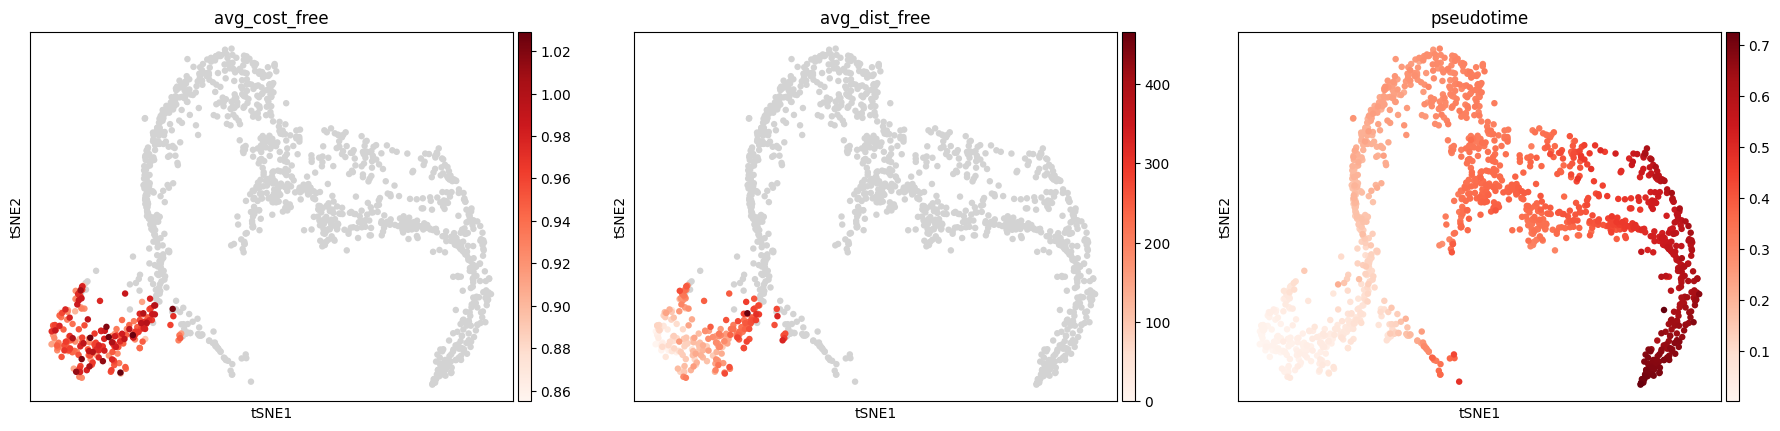

In [17]:
sc.pl.tsne(dataset1, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")

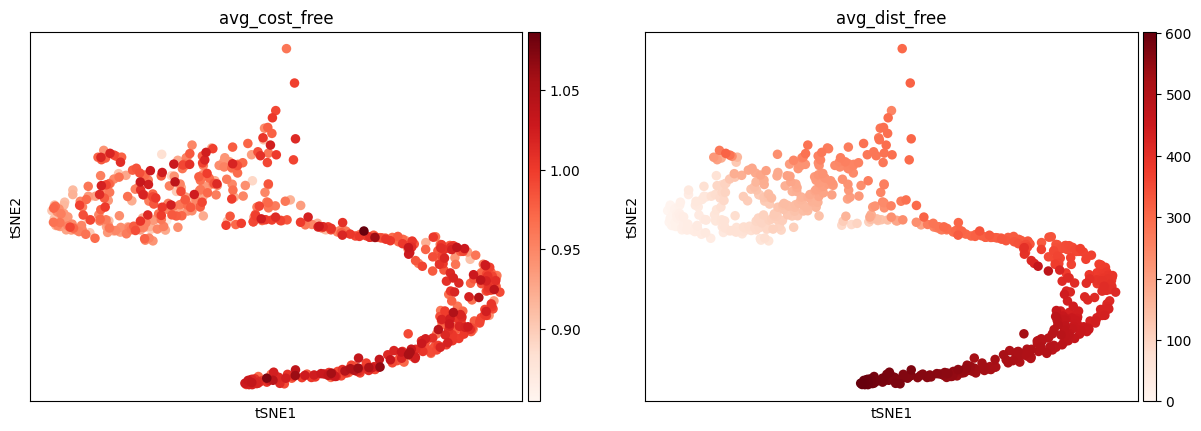

In [18]:
sc.pl.tsne(dataset2, color = ["avg_cost_free", "avg_dist_free"], cmap = "Reds")

In [19]:
path1 = res1.path1()[:-1]
path2 = res1.path2()[:-1]

d1_res_dist = avg_cost_path(path1[:-1], path2[:-1], res1.distances(), dataset1, dataset2)
d1_res_cost = avg_cost_path(path1[:-1], path2[:-1], res1.cost(), dataset1, dataset2)

dataset1.obs["avg_dist_on_path"] = pd.Series(d1_res_dist[1], index=d1_res_dist[0])
dataset2.obs["avg_dist_on_path"] = pd.Series(d1_res_dist[3], index=d1_res_dist[2])
dataset1.obs["avg_cost_on_path"] = pd.Series(d1_res_cost[1], index=d1_res_cost[0])
dataset2.obs["avg_cost_on_path"] = pd.Series(d1_res_cost[3], index=d1_res_cost[2])

/tmp/ipykernel_6633/697285008.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('Oranges_r', 128)
/tmp/ipykernel_6633/697285008.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('Blues', 128)


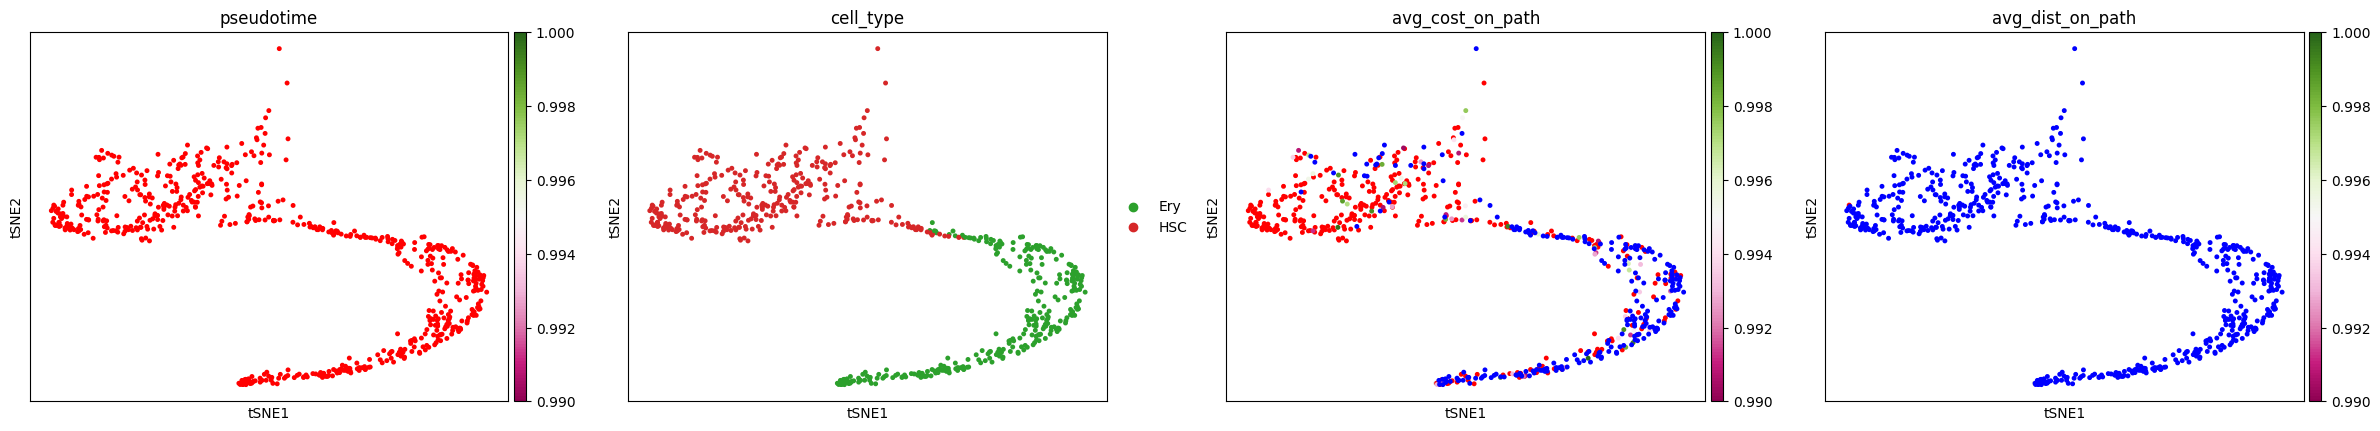

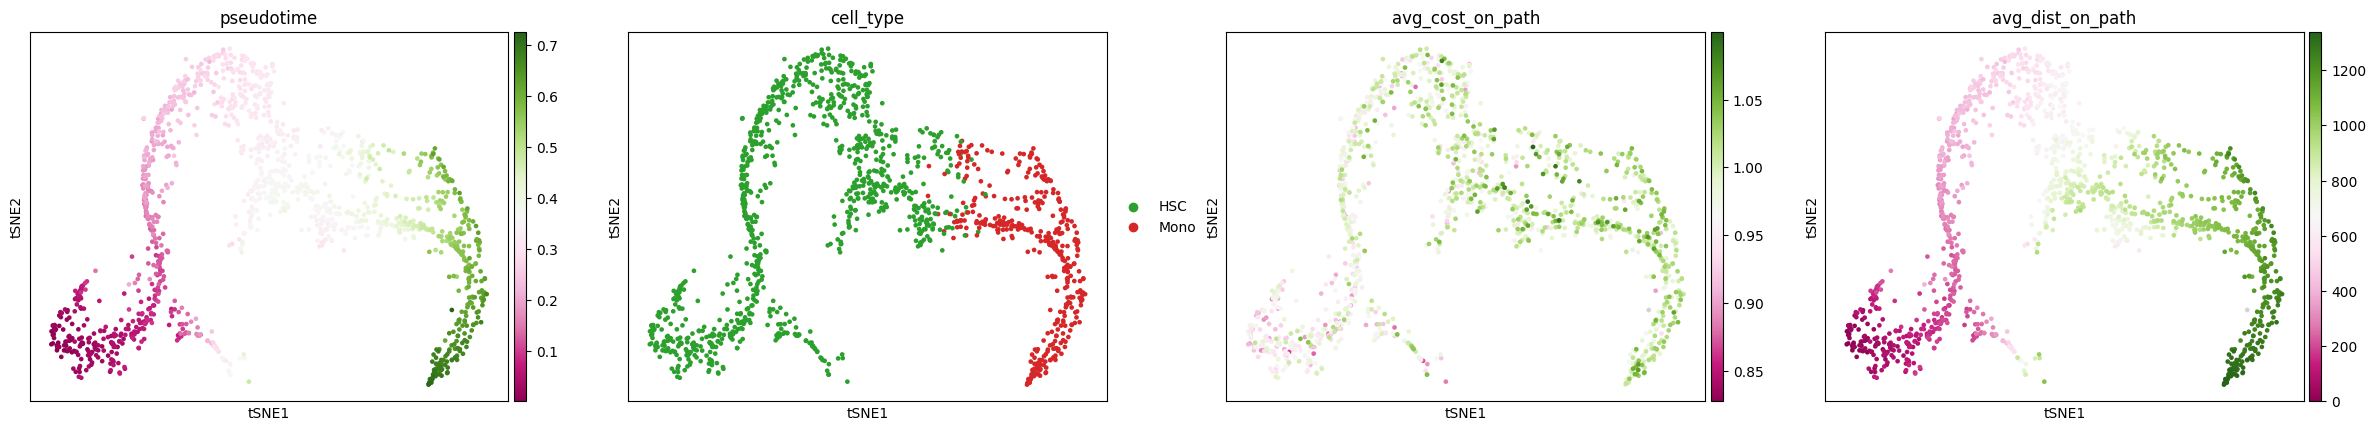

In [54]:
from matplotlib.colors import ListedColormap
from matplotlib import cm, pyplot as plt

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
cmap = plt.get_cmap('PiYG', 128)
cmap.set_under('red')
cmap.set_over('blue')

sc.pl.tsne(dataset2, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= cmap, vmin = 0.99, vmax = 1, s = 50)
sc.pl.tsne(dataset1, color = ["pseudotime", "cell_type", "avg_cost_on_path", "avg_dist_on_path"], cmap= "PiYG", s = 45)

In [21]:
dataset2.obs.sort_values("pseudotime")[["avg_cost_on_path", "avg_dist_on_path"]]

,avg_cost_on_path,avg_dist_on_path
index,,
Run2_196019714415387,0.911543,0.000000
Run2_240617688264027,0.938100,12.668023
Run2_200561481181556,0.915472,25.434446
Run2_121879202785691,0.946009,26.793663
Run3_170327476390772,0.922709,28.189205
...,...,...
Run1_240634626457004,0.988226,1336.190021
Run1_241057681271644,1.008838,1337.178248
Run2_226901487380198,0.963526,1338.187086


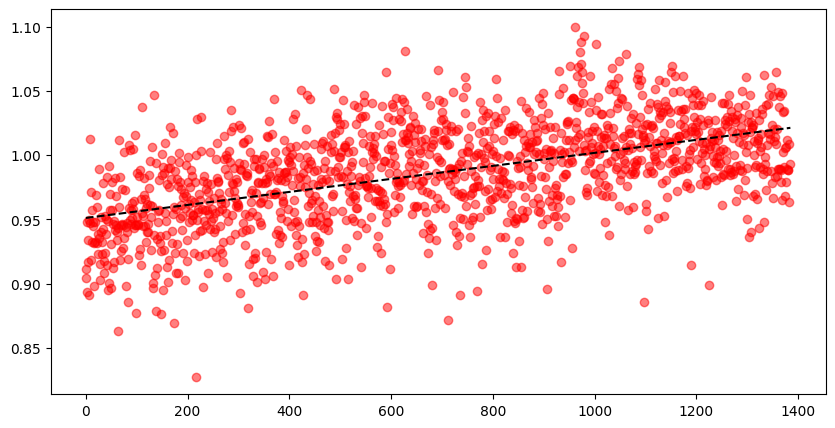

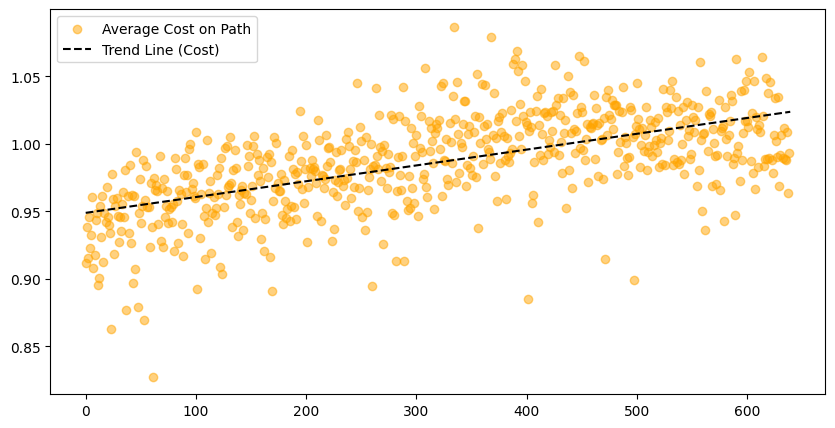

In [34]:
# plot the average cost and distance on the path  sorted by pseudotime
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
d1_avg_dist = dataset1.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d1_avg_cost = dataset1.obs.sort_values("pseudotime")["avg_cost_on_path"].values
d2_avg_dist = dataset2.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d2_avg_cost = dataset2.obs.sort_values("pseudotime")["avg_cost_on_path"].values




plt.scatter(range(len(d1_avg_cost)), d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(range(len(d1_avg_cost[:-1])), d1_avg_cost[:-1], 1)
plt.plot(range(len(d1_avg_cost)), b * np.array(range(len(d1_avg_cost))) + a, color='black', linestyle='--', label='Trend Line (Cost)')
plt.show()


plt.figure(figsize=(10, 5))
plt.scatter(range(len(d2_avg_cost)), d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(range(len(d2_avg_cost[:-1])), d2_avg_cost[:-1], 1)
plt.plot(range(len(d2_avg_cost)), b * np.array(range(len(d2_avg_cost))) + a, color='black', linestyle='--', label='Trend Line (Cost)') 
plt.legend()

plt.show()  

In [31]:
d1_avg_cost[:-1]

array([0.91154261, 0.9042232 , 0.9480712 , ..., 1.00883848, 0.9635257 ,
       0.99295883], shape=(1385,))

In [32]:
np.polyfit(range(len(d1_avg_cost[:-1])), d1_avg_cost[:-1], 1)

array([5.06432105e-05, 9.51103150e-01])

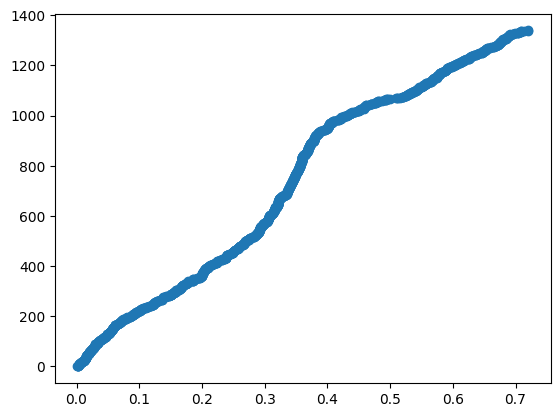

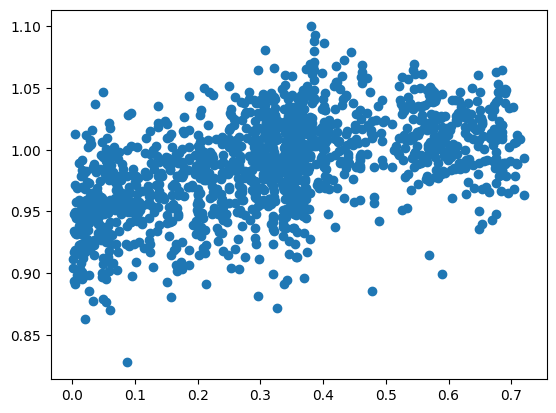

In [27]:
d1_pseudotime = dataset1.obs.sort_values("pseudotime")[["pseudotime"]].values
d2_pseudotime = dataset2.obs.sort_values("pseudotime")[["pseudotime"]].values

plt.scatter(d1_pseudotime, d1_avg_dist)
plt.show()
plt.scatter(d1_pseudotime, d1_avg_cost)

# Good alignment

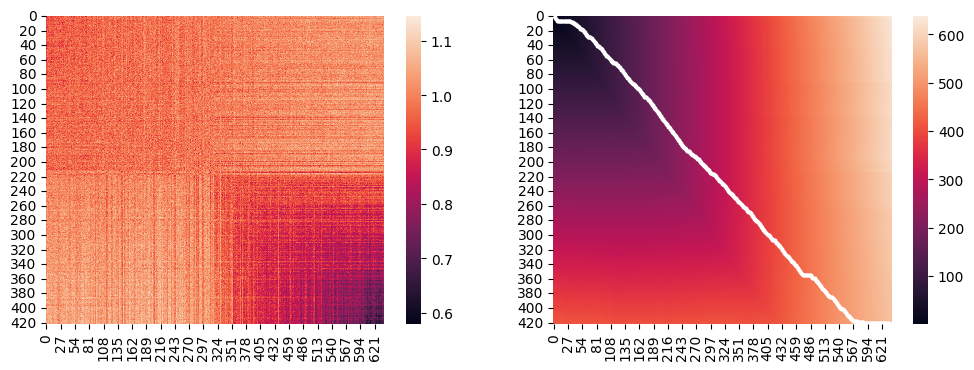

In [56]:
res2 = results_all_subsets[15][23][0]
res2.plot_cost_distances()

In [57]:
dataset1 = read_with_pc(f"data/rep{id_name[15]['rep']}_{id_name[15]['cell_type']}_subset{id_name[15]['subset']}_hvg.h5ad")
dataset2 = read_with_pc(f"data/rep{id_name[23]['rep']}_{id_name[23]['cell_type']}_subset{id_name[23]['subset']}_hvg.h5ad")

In [72]:
def skip_traceback_free2(D):
    # start from smallest value on the last row --> refers to j and q
    i = D.shape[0] - 1
    j = np.argmin(D[-1, :])

    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = np.argmin((D[i - 1, j - 1], D[i, j - 1], D[i - 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            j -= 1
        elif tb == 2:
            i -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

In [73]:
dist1 = res2.distances()
path1, path2 = skip_traceback_free2(dist1)

In [74]:
res2.cost()

array([[0.86903503, 0.90809377, 0.93777845, ..., 1.05877173, 1.00248103,
        1.05778794],
       [0.85798622, 0.90916534, 0.92538671, ..., 1.06875948, 0.99448629,
        1.05367009],
       [0.88745485, 0.95737973, 0.89197709, ..., 1.05163369, 1.0677501 ,
        1.04719338],
       ...,
       [1.04331925, 1.05935804, 1.05364481, ..., 0.66347519, 0.73400085,
        0.66049776],
       [1.03884062, 1.05336899, 1.07465469, ..., 0.6734117 , 0.69337288,
        0.61071857],
       [1.02159901, 1.04973696, 1.05739136, ..., 0.66891843, 0.72208281,
        0.61310069]], shape=(422, 640))

In [75]:
index1f, ac1f, index2f, ac2f = avg_cost_path(path1, path2, res2.cost(), dataset1, dataset2)
index1f, ad1f, index2f, ad2f = avg_cost_path(path1, path2, res2.distances(), dataset1, dataset2)

In [76]:
dataset1.obs["avg_cost_free"] = pd.Series(ac1f, index=index1f)
dataset2.obs["avg_cost_free"] = pd.Series(ac2f, index=index2f)
dataset1.obs["avg_dist_free"] = pd.Series(ad1f, index=index1f)
dataset2.obs["avg_dist_free"] = pd.Series(ad2f, index=index2f)

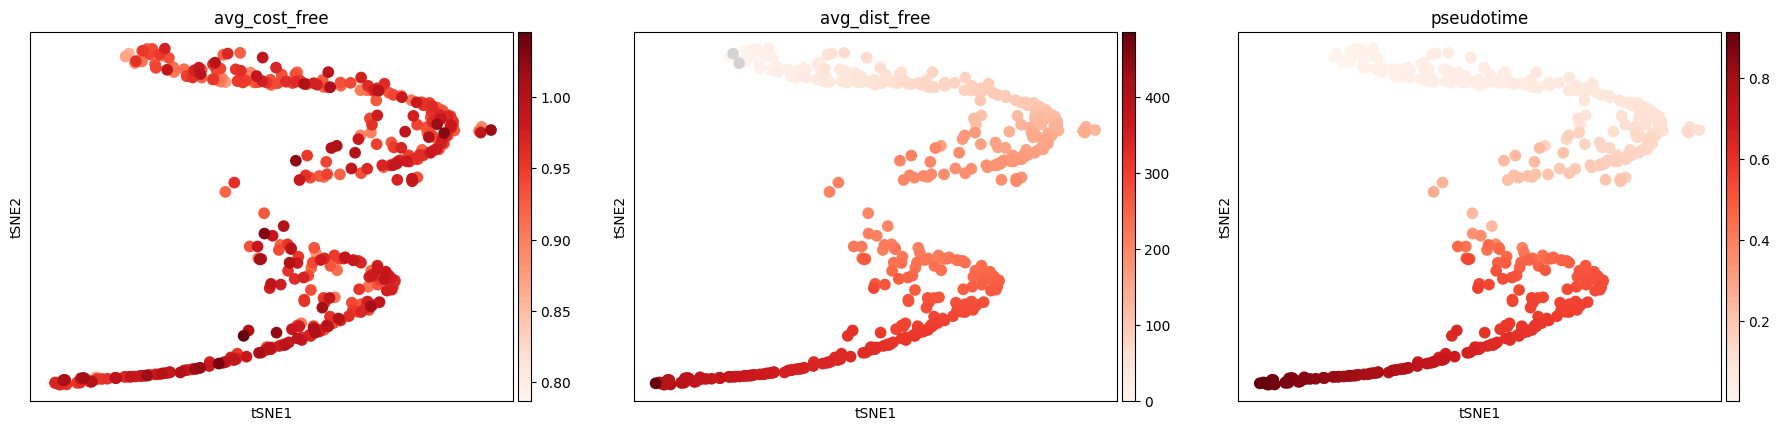

In [77]:
sc.pl.tsne(dataset1, color = ["avg_cost_free", "avg_dist_free", "pseudotime"], cmap = "Reds")

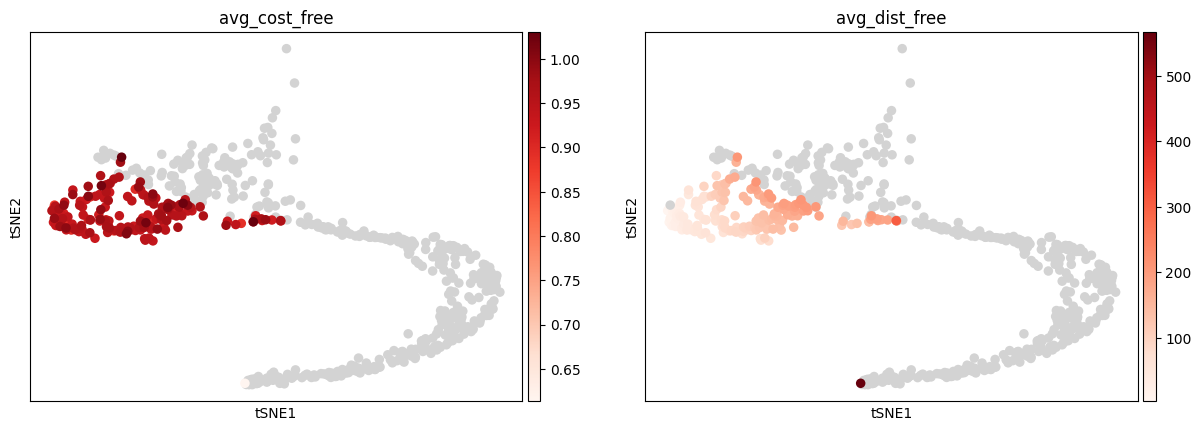

In [78]:
sc.pl.tsne(dataset2, color = ["avg_cost_free", "avg_dist_free"], cmap = "Reds")

In [79]:
path1 = res2.path1()[:-1]
path2 = res2.path2()[:-1]

d1_res_dist = avg_cost_path(path1[:-1], path2[:-1], res2.distances(), dataset1, dataset2)
d1_res_cost = avg_cost_path(path1[:-1], path2[:-1], res2.cost(), dataset1, dataset2)

dataset1.obs["avg_dist_on_path"] = pd.Series(d1_res_dist[1], index=d1_res_dist[0])
dataset2.obs["avg_dist_on_path"] = pd.Series(d1_res_dist[3], index=d1_res_dist[2])
dataset1.obs["avg_cost_on_path"] = pd.Series(d1_res_cost[1], index=d1_res_cost[0])
dataset2.obs["avg_cost_on_path"] = pd.Series(d1_res_cost[3], index=d1_res_cost[2])

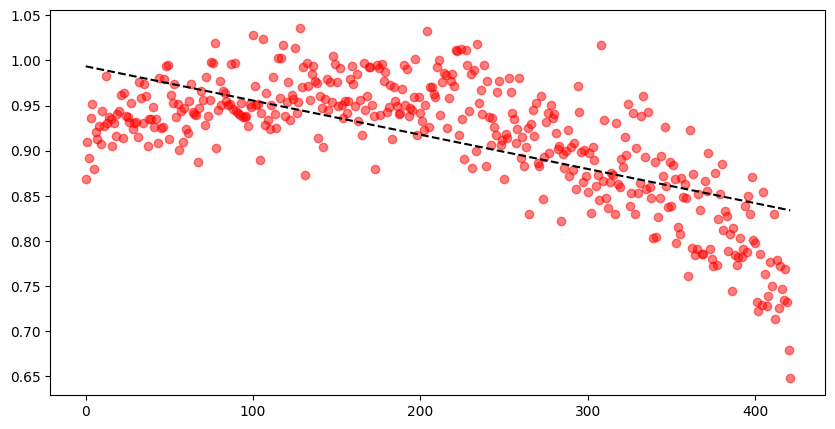

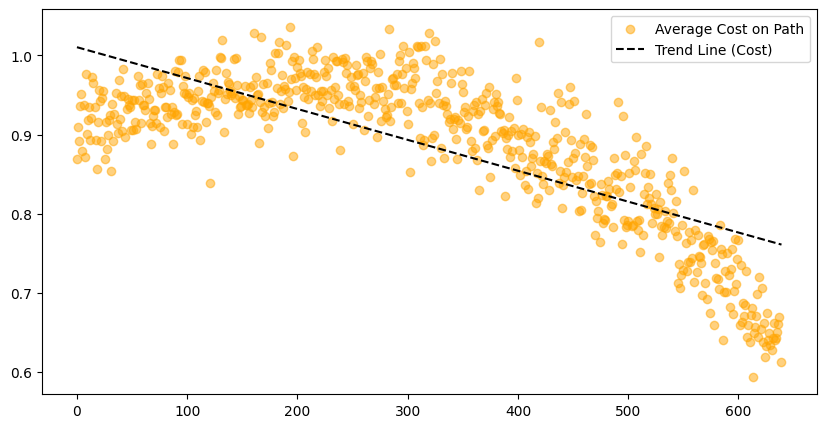

In [85]:
# plot the average cost and distance on the path  sorted by pseudotime
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
d1_avg_dist = dataset1.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d1_avg_cost = dataset1.obs.sort_values("pseudotime")["avg_cost_on_path"].values
d2_avg_dist = dataset2.obs.sort_values("pseudotime")["avg_dist_on_path"].values
d2_avg_cost = dataset2.obs.sort_values("pseudotime")["avg_cost_on_path"].values




plt.scatter(range(len(d1_avg_cost)), d1_avg_cost, label="Average Cost on Path", color='red', alpha=0.5)
b, a = np.polyfit(range(len(d1_avg_cost[:-1])), d1_avg_cost[:-1], 1)
plt.plot(range(len(d1_avg_cost)), b * np.array(range(len(d1_avg_cost))) + a, color='black', linestyle='--', label='Trend Line (Cost)')
plt.show()


plt.figure(figsize=(10, 5))
plt.scatter(range(len(d2_avg_cost)), d2_avg_cost, label="Average Cost on Path", color='orange', alpha=0.5)
b, a = np.polyfit(range(len(d2_avg_cost[:-2])), d2_avg_cost[:-2], 1)
plt.plot(range(len(d2_avg_cost)), b * np.array(range(len(d2_avg_cost))) + a, color='black', linestyle='--', label='Trend Line (Cost)') 
plt.legend()

plt.show()  